In [2]:
import xml.etree.ElementTree as ET
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from skimage.util import img_as_float
from skimage import io, color
from scipy import misc
from skimage.segmentation import slic, mark_boundaries
import cv2
import matplotlib.pyplot as plt
import pickle

In [482]:
'''
Given XML file, gets the xy positions for text block
'''
def get_xy_coordinates(filename):    
    # Give location of XML document
    tree = ET.parse(filename)
#     tree = ET.parse('d-006_kai.chen@unifr.ch.xml')
    root = tree.getroot()

    # Get the page
    for child in root:
        if child.tag == 'Page':
            page = child

    # Identify all (x,y) corresponding to text blok
    coordinates_extended = []
    coordinates_appended = []
    for region in page.findall('TextRegion'):
        coords = region.find('Coords')
        label = region.get('type')
        if label=='text':
#             labels.append(label)
            xy = []
            for point in coords.findall('Point'):
                x = int(point.get('x'))
                y = int(point.get('y'))
                x = x*0.125
                y = y*0.125
                xy.append((x,y))
            coordinates_extended.extend(xy)
            coordinates_appended.append(xy)
    # return
    return coordinates_extended, coordinates_appended

In [4]:
'''
Reads the image and scales it by a factor of 2^-3
'''
def read_image(img_file):
    # Read input image
    image = img_as_float(io.imread(img_file))
    image = color.rgb2gray(io.imread(img_file))
    image = misc.imresize(image, 0.125, interp='nearest', mode=None)
    # plt.imshow(image, cmap='gray')
    # plt.show()
    return image

In [5]:
'''
Creat image segments using SLIC.
Returns: mask and the pixel intensities for every region.
'''
def SLIC(num):
    masks = []
    Regions = []
    segments = slic(image, n_segments = num)
    
    for (i, segVal) in enumerate(np.unique(segments)):
        # construct a mask for the segment
        mask = np.zeros(image.shape[:2], dtype = "uint8")
        mask[segments == segVal] = 255
        seg = cv2.bitwise_and(image, image, mask = mask)
        r = cv2.bitwise_and(image, image, mask = mask)
        masks.append(mask)
        Regions.append(r)
    masks = np.array(masks)
    Regions = np.array(Regions)
    return masks, Regions, segments

In [6]:
def view_segments(image, segments):
    fig = plt.figure("Superpixels -- %d segments" % (1000))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")

    # show the plots
    plt.show()

In [486]:
'''
Get input images (kxk) for the CNN and their borders
'''
def get_images_borders(Regions, total_rows, k, total_cols):
    input_images = []
    all_coordinates = []
    all_coordinates_extened = []
#     for i in range(len(Regions)):
    i = 0
    for r in range(0,total_rows-k+1,k):
        for c in range(0,total_cols-k+1,k):
            input_images.append(Regions[i][r:r+k,c:c+k])
            all_coordinates.append([(r,c),(r,c+k-1),(r+k-1,c+k-1),(r+k-1,c)])
            i += 1
                
#     all_coordinates = np.array(all_coordinates)
    input_images = np.array(input_images)
    
    input_images_f = []
    all_coordinates_f = []
    # Remove all zero images
    for j in range(len(input_images)):
        if not (input_images[j]==0).all():
            input_images_f.append(input_images[j])
            all_coordinates_f.append(all_coordinates[j])
            all_coordinates_extened.extend(all_coordinates[j])
    return input_images_f, all_coordinates_f, all_coordinates_extened

In [495]:
def make_training_data(input_images, all_coordinates, xy_append):
    training_data = [] # col 0 : Image, col 1 : Label;  Label = 1 => Text
    for i in range(len(all_coordinates)):
        data = []
        coordinate = all_coordinates[i]
        img = input_images[i]
        data.append(img)
        label = 0
        for coord in coordinate:
            point = Point(coord)
            for text_block in xy_append:
                polygon = Polygon(text_block) 
                if polygon.contains(point):
                    label = 1
                    break
            if label == 1:
                break
        data.append(label)
        training_data.append(data)
    training_data = np.array(training_data)
    return training_data

In [496]:
'''
Calling Functions
'''
image = read_image("d-006.jpg") # Read Image

masks, Regions, segments = SLIC(1000) # Perform SLIC into 1000 segments

# view_segments(image, segments) # To Plot segments

xy_extend, xy_append = get_xy_coordinates('d-006.xml') # Get (x,y) from the xml file

k = np.count_nonzero(masks[0][0]) # Get dimension of input image (kxk)

total_rows = Regions.shape[1]

total_columns = Regions.shape[2]

input_images, all_coordinates, all_coordinates_extened = get_images_borders(Regions, total_rows, k, total_columns)

training_data = make_training_data(input_images, all_coordinates, xy_append)

In [500]:
'''
To Dump or load from pickle files
'''
# pickle_file = open('training_data.pkl', 'wb')
# pickle.dump(training_data, pickle_file)
# pickle_file.close()
# input_images = pickle.load(open('input_images.pkl','r'))
# all_coordinates = pickle.load(open('all_coordinates.pkl','r'))
training_data = pickle.load(open('training_data.pkl','r'))

In [502]:
np.count_nonzero(training_data[:,1])

317

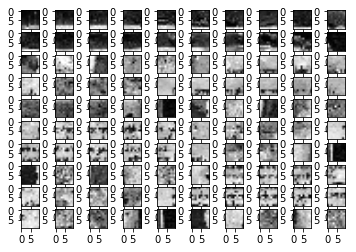

In [506]:

f, axarr = plt.subplots(10, 10)
for i in range(100):
    axarr[i/10,i%10].imshow(input_images[i+30], interpolation='bilinear', cmap='gray')
plt.show()